# Natural Language Processing   

Mini-Challenge 1 (LE3-LE5)   
Yannic & Ben  


# Aufgabe

You evaluate 2 different classification systems on a text classification task (examples below). You argument why you chose these systems for that case and you build, train and evaluate the system. You also do a thorough error analysis and propose theories on how to improve the systems, especially also by analysing individual cases and comparing the predictions of each system. At least one of the systems is based on a fine-tuned deep learning model.

Here you can use data from shared tasks, such as semeval, kaggle, codalab or paperwithcode for text classification.

You can submit as a group of 2 but each one has to have a significant contribution. Submission is given as a gitlab repo. I will track with the commit history if there was  a significant contribution from each participant. The repo should include the report, a python notebook to reproduce the results and a wiki with a journal or git issues that document the progress of your mini-challenge.

Since many parts of code can be online, the most important part of the submission will be the report and evaluation of the results. In the report you describe which system you used, which are the theory behind it and why you chose it. The evaluation you describe the metric chose, why this metric is good for the use case and discuss the results of the experiments and some predictions on individual test samples. Bonus points will be given if you show, that you implemented the systems yourself, and the progress/errors are documented through commits.

ADDENDUM: The classification systems can be for example tf-idf-svm, cnns or transformers, see https://gitlab.fhnw.ch/fernando.benites/npr-21-fs/-/tree/master/text_classification/20news_group for an applied example. There are other ways to go, and I am open for suggestions. Please try to understand the systems, this can be handy in the error analysis/evaluation/report or in the exam. Don't use the 20newsgroup dataset. The repo will be used in the deep dive and so this dataset is already "taken". If you receive a 404 on the repo, please contact me, I'll add you to the repo, then it should work.

Some other starting points:

https://lionbridge.ai/articles/using-deep-learning-for-end-to-end-multiclass-text-classification/

BETTER: https://medium.com/analytics-vidhya/sentiment-analysis-on-amazon-reviews-using-tf-idf-approach-c5ab4c36e7a1

GOOD: https://colab.research.google.com/github/patrickvankessel/AAPOR-Text-Analysis-2019/blob/master/Tutorial.ipynb#scrollTo=9wJQJUDHkM5w

BAD: https://medium.com/@qempsil0914/machine-learning-nlp-text-classification-with-amazon-review-data-using-python3-step-by-step-3fb0cc0cecc1

https://paperswithcode.com/task/text-classification

https://fbenites.github.io/GermEval/

https://medium.com/analytics-vidhya/fine-tuning-bert-language-model-to-get-better-results-on-text-classification-3dac5e3c348e

https://github.com/Shivampanwar/Bert-text-classification/blob/master/bert_language_model_with_sequence_classification.ipynb


# Installing Packages

In [2]:
# Standard Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# SVM Classifier
from sklearn.svm import SVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


# Metrics
from sklearn.metrics import classification_report, accuracy_score, f1_score

# nltk imports
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to C:\Users\Si Ben
[nltk_data]     Tran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Si Ben
[nltk_data]     Tran\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Si Ben
[nltk_data]     Tran\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Si Ben Tran\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Read Dataset

In [3]:
# Read booksumaries.txt Dataset
df = pd.read_csv('data/booksummaries.txt', 
                 sep="\t", 
                 header=None, 
                 names=["wikipedia_id", "freebase_id", "book_title", "book_author", "pub_date","genres","summary"],
                 dtype={"wikipedia_id": np.int32, "freebase_id": str, "book_title": str, "book_author": str, "pub_date": str, "genres": str, "summary": str})

df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   wikipedia_id  16559 non-null  int32 
 1   freebase_id   16559 non-null  object
 2   book_title    16559 non-null  object
 3   book_author   14177 non-null  object
 4   pub_date      10949 non-null  object
 5   genres        12841 non-null  object
 6   summary       16559 non-null  object
dtypes: int32(1), object(6)
memory usage: 841.0+ KB


,wikipedia_id,freebase_id,book_title,book_author,pub_date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ..."
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...


# Data Wrangle Dataset

In [4]:
def extract_genres(genre_str: str):
    """
    Extract the genres from the given string.

    Parameters:
    genre_str (str): input string

    Returns:
    list: list of genres
    """
    try:
        genre_data = json.loads(genre_str)
        return list(genre_data.values())
    except:
        (json.decoder.JSONDecodeError, TypeError)
        return np.nan
    

def drop_na_duplicates(df: pd.DataFrame):
    """
    Drop rows with missing values in the genres and summary columns and drop duplicate rows.

    Parameters:
    df (DataFrame): input data

    Returns:
    DataFrame: data with missing values and duplicates dropped
    """
    return df.dropna(subset=['genres', 'summary']).drop_duplicates(subset=["summary"]).reset_index(drop=True)


def wrangle_genres(df, minimum_genre_occurence=5):
    """
    Wrangle the genres column of the given dataframe, removing rows with genres that occur less than the given minimum_genre_occurence.

    Parameters:
    df (DataFrame): input data

    Returns:
    DataFrame: data with genres wrangled
    """
    # create copy of dataframe to avoid changing the original
    df_wrangle = df.copy()

    # Turn genres into set
    df_wrangle['genres'] = df_wrangle['genres'].apply(set)

    # Convert genres sets to strings to count occurrences
    df_count = pd.DataFrame(df_wrangle['genres'].value_counts()).reset_index()
    
    # Filter rows where genres occur more than 5 times
    selected_rows = df_count[df_count['count'] > minimum_genre_occurence]['genres']
    df_wrangle = df_wrangle[df_wrangle['genres'].isin(selected_rows)]
    
    # Turn back into list
    df_wrangle['genres'] = df_wrangle['genres'].apply(list)

    return df_wrangle

# create functio to wrangle summaries
def wrangle_summary(df, minimum_quantile=0.01):
    """
    Wrangle the summary column of the given dataframe, removing rows with summaries that are longer than the given minimum_quantile.

    Parameters:
    df (DataFrame): input data

    Returns:
    DataFrame: data with summaries wrangled
    """
    # create copy of dataframe to avoid changing the original
    df_wrangle = df.copy()

    # Filter rows where summaries are shorter than 10% quantile
    df_wrangle = df_wrangle[df_wrangle['summary'].str.len() > df_wrangle['summary'].str.len().quantile(minimum_quantile)]

    return df_wrangle

# copy Dataframe to avoid changing the original
df_unwrangled = df.copy()

# First Preprocessing
# extract genre
# apply extract_genres function to the Genres column
df_unwrangled['genres'] = df_unwrangled['genres'].apply(extract_genres)

# drop na rows and duplicates
df_unwrangled = drop_na_duplicates(df=df_unwrangled)

# wrangle genres
df_unwrangled = wrangle_genres(df=df_unwrangled, minimum_genre_occurence=5)

# wrangle summary
df_wrangled = wrangle_summary(df=df_unwrangled, minimum_quantile=0.01)

# display unprocessed dataframe
display(df_wrangled)


def analyze_dataframe(df, df_wrangled):
    """
    Analyze the difference between two DataFrames.

    Parameters:
    df (DataFrame): original DataFrame
    df_wrangled (DataFrame): wrangled DataFrame

    Returns:
    dict: a dictionary containing the analysis results
    """
    analysis_results = {}
    
    # Calculate the number of dropped rows
    num_dropped_rows = df.shape[0] - df_wrangled.shape[0]
    analysis_results["Number of dropped rows"] = num_dropped_rows
    
    # Calculate the relative number of dropped rows in percent and round to 2 decimal places
    relative_dropped_percent = round((num_dropped_rows / df.shape[0]) * 100, 2)
    analysis_results["Relative number of dropped rows in percent"] = f"{relative_dropped_percent}%"
    
    # Calculate the number of unique genres
    num_unique_genres = df_wrangled['genres'].explode().nunique()
    analysis_results["Number of unique genres"] = num_unique_genres

    # copy Dataframe to avoid changing the original
    df_wrangle = df_wrangled.copy()

    # count unique combinations of elemnts in lists within a specified DataFrame column
    df_wrangle['genres'] = df_wrangle['genres'].apply(lambda x: set(sorted(x)) if isinstance(x, list) else x)
    
    # Count occurrences of each unique combination
    combination_counts = df_wrangle['genres'].value_counts().reset_index().shape[0]
    analysis_results["Number of unique genre combinations"] = combination_counts
    
    return analysis_results

# analyze the difference between the original and the wrangled dataframe
print(analyze_dataframe(df=df, df_wrangled=df_wrangled))



,wikipedia_id,freebase_id,book_title,book_author,pub_date,genres,summary
6,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"[Speculative fiction, Science Fiction]","Living on Mars, Deckard is acting as a consul..."
7,4082,/m/01b56,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,"[Speculative fiction, Science Fiction]",Beginning several months after the events in ...
9,6020,/m/01t5z,Crash,J. G. Ballard,1973,"[Speculative fiction, Fiction, Novel]",The story is told through the eyes of narrato...
10,6628,/m/01y92,Children of Dune,Frank Herbert,1976,"[Children's literature, Speculative fiction, F...",Nine years after Emperor Paul Muad'dib walked...
12,6630,/m/01yb0,Chapterhouse Dune,Frank Herbert,1985-04,"[Children's literature, Speculative fiction, F...",The situation is desperate for the Bene Gesse...
...,...,...,...,...,...,...,...
12811,36126792,/m/044psh,Gates of Paradise,V. C. Andrews,1989-06,"[Young adult literature, Gothic fiction]","A novel about Annie Stonewall, the daughter o..."
12812,36372465,/m/02vqwsp,The Third Lynx,Timothy Zahn,2007,[Science Fiction],The story starts with former government agent...
12813,36534061,/m/072y44,Remote Control,Andy McNab,1997,"[Suspense, Fiction, Thriller]",The series follows the character of Nick Ston...
12814,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"[Fiction, Thriller]",The reader first meets Rapp while he is doing...


{'Number of dropped rows': 6675, 'Relative number of dropped rows in percent': '40.31%', 'Number of unique genres': 57, 'Number of unique genre combinations': 228}


# Explorative Daten Analyse

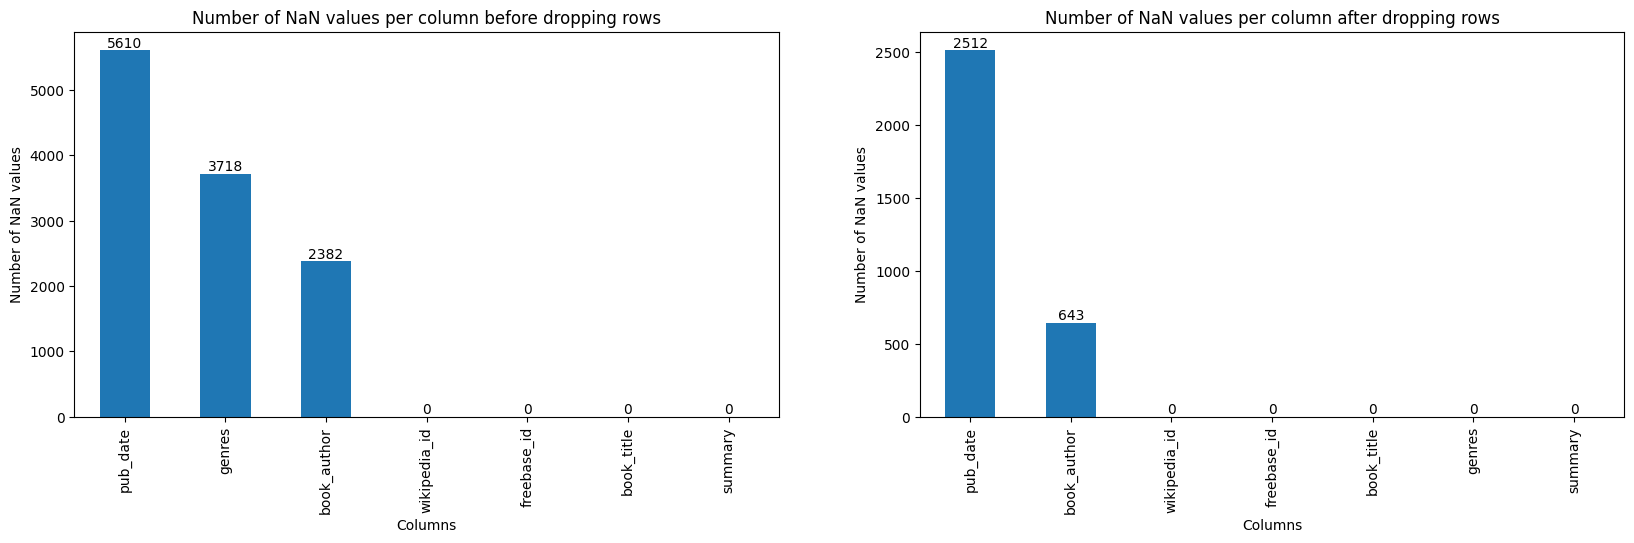

In [5]:
# befor and after wrangling
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
df.isna().sum().sort_values(ascending=False).plot(kind='bar', ax=axes[0])
for index, value in enumerate(df.isna().sum().sort_values(ascending=False)):
    axes[0].text(index, value, str(value), ha='center', va='bottom', fontsize=10)
axes[0].set_title('Number of NaN values per column before dropping rows')
axes[0].set_xlabel('Columns')
axes[0].set_ylabel('Number of NaN values')

df_wrangled.isna().sum().sort_values(ascending=False).plot(kind='bar', ax=axes[1])
for index, value in enumerate(df_wrangled.isna().sum().sort_values(ascending=False)):
    axes[1].text(index, value, str(value), ha='center', va='bottom', fontsize=10)
axes[1].set_title('Number of NaN values per column after dropping rows')
axes[1].set_xlabel('Columns')
axes[1].set_ylabel('Number of NaN values')
plt.show()

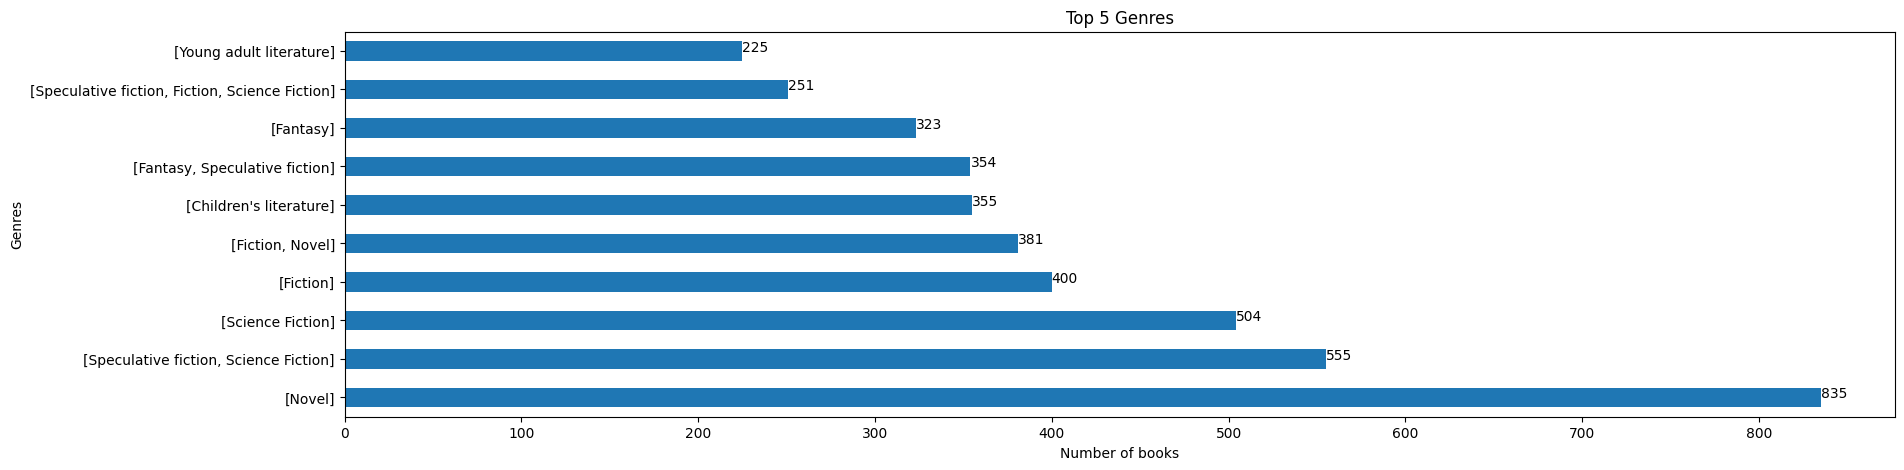

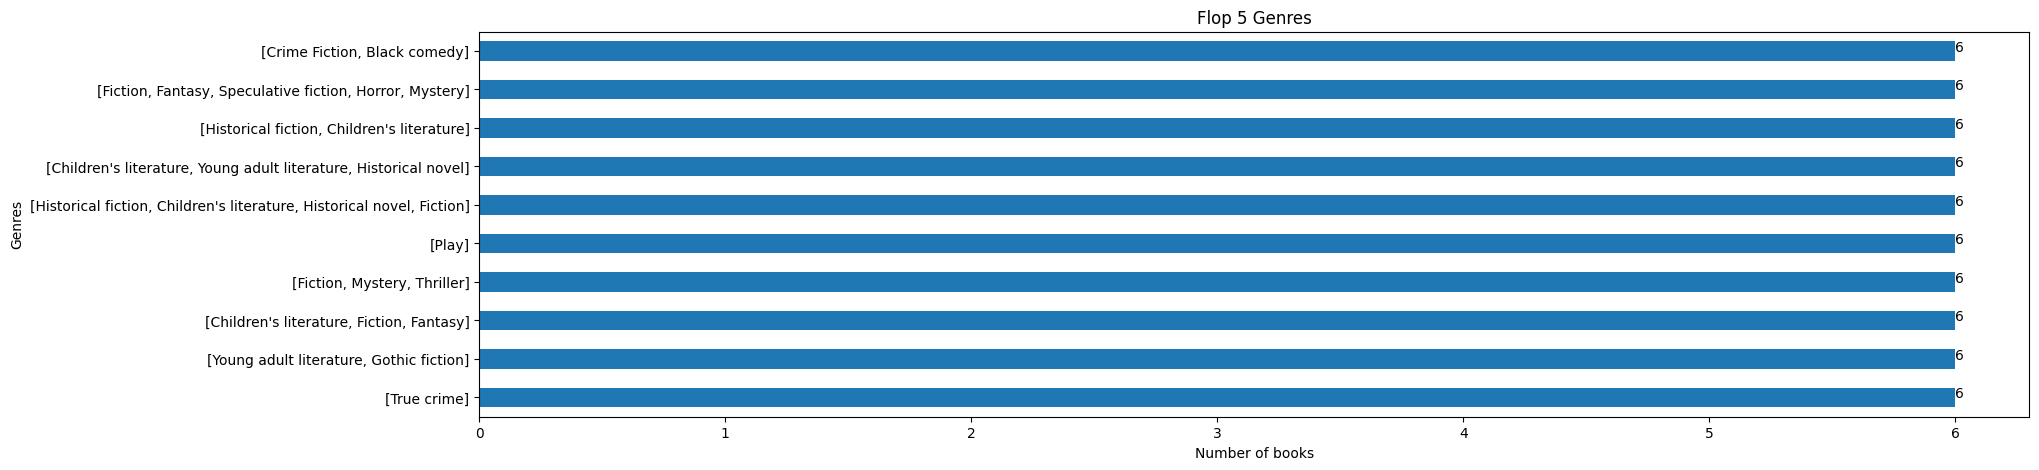

In [6]:
# Top 10 Genres
df_wrangled["genres"].value_counts().head(n=10).plot(kind='barh', figsize=(20, 5))
# add number to the bars
for index, value in enumerate(df_wrangled["genres"].value_counts().head(n=10)):
    plt.text(value, index, str(value), fontsize=10)
plt.title('Top 5 Genres')
plt.xlabel('Number of books')
plt.ylabel('Genres')
plt.show()

# Flop 3 Genres
df_wrangled["genres"].value_counts().tail(10).plot(kind='barh', figsize=(20, 5))
# add number to the bars
for index, value in enumerate(df_wrangled["genres"].value_counts().tail(10)):
    plt.text(value, index, str(value))
plt.title('Flop 5 Genres')
plt.xlabel('Number of books')
plt.ylabel('Genres')
plt.show()


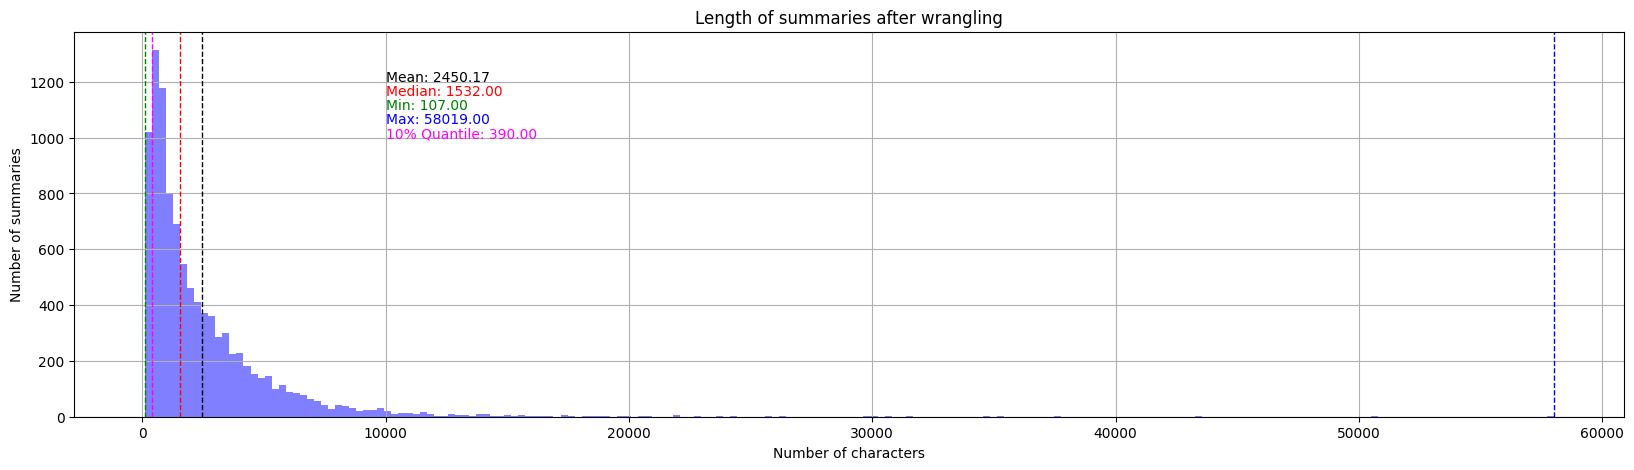

In [7]:
# create a histogram of the len of the summaries
df_wrangled['summary'].str.len().hist(figsize=(20, 5), bins=200, color='blue', alpha = 0.5)
plt.axvline(df_wrangled['summary'].str.len().mean(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().median(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().min(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().max(), color='b', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().quantile(0.1), color='magenta', linestyle='dashed', linewidth=1)

mean_length = df_wrangled['summary'].str.len().mean()
median_length = df_wrangled['summary'].str.len().median()
min_length = df_wrangled['summary'].str.len().min()
max_length = df_wrangled['summary'].str.len().max()
quantile_10 = df_wrangled['summary'].str.len().quantile(0.1)

# add labels from axvline
plt.text(10000, 1200, f'Mean: {mean_length:.2f}', fontsize=10, color='black')
plt.text(10000, 1150, f'Median: {median_length:.2f}', fontsize=10, color='r')
plt.text(10000, 1100, f'Min: {min_length:.2f}', fontsize=10, color='g')
plt.text(10000, 1050, f'Max: {max_length:.2f}', fontsize=10, color='b')
plt.text(10000, 1000, f'10% Quantile: {quantile_10:.2f}', fontsize=10, color='magenta')

plt.title('Length of summaries after wrangling')
plt.xlabel('Number of characters')
plt.ylabel('Number of summaries')
plt.show()

# Data NLP Pre-processing

In [10]:
# select the relevant columns
df_nlp = df_wrangled[['genres', 'summary']].copy()

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))

# preprocess Summary column and add it to the dataframe
def preprocess_summary(summary_text: str):
    # case folding to lower case 
    summary_text = summary_text.lower()
    # remove punctuation, kommas, dots, and other special characters
    summary_text = summary_text.translate(str.maketrans('', '', string.punctuation))
    # remove stopwords
    summary_text = [word for word in summary_text.split() if word not in stop_words]
    # lemmatize words
    summary_text = [WordNetLemmatizer().lemmatize(word) for word in summary_text]
    # Tokenize
    summary_text = word_tokenize(" ".join(summary_text))
    return summary_text

# apply preprocess function to Summary column
df_nlp['tokens'] = df_nlp['summary'].apply(preprocess_summary)

def pos_tag_text(tokens: list):
    pos_tagged = nltk.pos_tag(tokens)
    # Returning the tags as a string
    return pos_tagged

# apply pos_tag_text function to Summary column
df_nlp['POS-Tag'] = df_nlp['tokens'].apply(pos_tag_text)

# turn tokens from list to str
df_nlp['tokens'] = df_nlp['tokens'].apply(lambda x: " ".join(x))

# select relevant columns for classification
df_preprocessed = df_nlp[['genres', 'tokens', 'POS-Tag']].copy()

# display DataFrame
display(df_preprocessed)


,genres,tokens,POS-Tag
6,"[Speculative fiction, Science Fiction]",living mar deckard acting consultant movie cre...,"[(living, VBG), (mar, NN), (deckard, NN), (act..."
7,"[Speculative fiction, Science Fiction]",beginning several month event blade runner dec...,"[(beginning, VBG), (several, JJ), (month, NN),..."
9,"[Speculative fiction, Fiction, Novel]",story told eye narrator james ballard named au...,"[(story, NN), (told, VBD), (eye, NN), (narrato..."
10,"[Children's literature, Speculative fiction, F...",nine year emperor paul muaddib walked desert b...,"[(nine, CD), (year, NN), (emperor, NN), (paul,..."
12,"[Children's literature, Speculative fiction, F...",situation desperate bene gesserit find target ...,"[(situation, NN), (desperate, JJ), (bene, NN),..."
...,...,...,...
12811,"[Young adult literature, Gothic fiction]",novel annie stonewall daughter heaven casteel ...,"[(novel, JJ), (annie, NN), (stonewall, NN), (d..."
12812,[Science Fiction],story start former government agent frank comp...,"[(story, NN), (start, VB), (former, JJ), (gove..."
12813,"[Suspense, Fiction, Thriller]",series follows character nick stone exmilitary...,"[(series, NN), (follows, VBZ), (character, JJR..."
12814,"[Fiction, Thriller]",reader first meet rapp covert operation iran d...,"[(reader, NN), (first, RB), (meet, VB), (rapp,..."


# Sandbox with mono variable

Fernando: n-grams anschauen -> Feature Extraction

Feature Weighting: Tf-idf
Feature Extraction: n-grams, Welche Spalte relevant, 

In [9]:
# Create a function where we only keep the Genres that have a length of 1 
def filter_genres(genres: list):
    return len(genres) == 1

# copy dataframe for filtering
df_mono_variable = df_preprocessed.copy()

# apply filter_genres function to Genres column
mask = df_mono_variable['genres'].apply(filter_genres)

# use the mask to filter the dataframe
df_mono_variable = df_mono_variable[mask].reset_index(drop=True)

# Elemnts should not be lists for genres and tokens 
df_mono_variable['genres'] = df_mono_variable['genres'].apply(lambda x: x[0])

# display the filtered dataframe
df_mono_variable.info()

# display the filtered dataframe
display(df_mono_variable)

# split the dataframe into train and test data
X_train, X_test, Y_train, Y_test  = train_test_split(df_mono_variable["tokens"], 
                                     df_mono_variable["genres"],
                                     test_size=0.2, 
                                     random_state=42)

# get shape of train and test data
print("Train: ",X_train.shape,Y_train.shape,"Test: ",(X_test.shape,Y_test.shape))

# initialize tfidf vectorizer
vectorizer = TfidfVectorizer()

# fit and transform the vectorizer on the train data
X_train = vectorizer.fit_transform(X_train)

# transform the vectorizer on the test data
X_test = vectorizer.transform(X_test)

# display the shape of the train and test data
print("Train: ",X_train.shape,"Test: ",X_test.shape)

# initialize the classifier
clf = SVC()

# fit the classifier on the train data
clf.fit(X_train, Y_train)

# predict the labels on the test data
Y_pred = clf.predict(X_test)

# calculate the accuracy score
print("Accuracy Score: ", accuracy_score(Y_test, Y_pred))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4553 entries, 0 to 4552
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Genres   4553 non-null   object
 1   tokens   4553 non-null   object
 2   POS-Tag  4553 non-null   object
dtypes: object(3)
memory usage: 106.8+ KB


,Genres,tokens,POS-Tag
0,Religious text,book job tell story extremely righteous man na...,"[(book, NN), (job, NN), (tell, VBP), (story, N..."
1,Gothic fiction,story presented le fanu part casebook dr hesse...,"[(story, NN), (presented, VBN), (le, JJ), (fan..."
2,Fiction,homer well grows orphanage spends childhood us...,"[(homer, NN), (well, RB), (grows, VBZ), (orpha..."
3,Fiction,death hero story young english artist named ge...,"[(death, NN), (hero, NN), (story, NN), (young,..."
4,Religious text,egypt pharaoh fearful israelite number order n...,"[(egypt, NN), (pharaoh, NN), (fearful, JJ), (i..."
...,...,...,...
4548,Non-fiction,beginning book marcus luttrell describes child...,"[(beginning, VBG), (book, NN), (marcus, NN), (..."
4549,Fiction,story set fictional housing unit london nickna...,"[(story, NN), (set, VBN), (fictional, JJ), (ho..."
4550,Young adult literature,prologue angel vision max deaththe book start ...,"[(prologue, NN), (angel, NN), (vision, NN), (m..."
4551,Science Fiction,story start former government agent frank comp...,"[(story, NN), (start, VB), (former, JJ), (gove..."


# Feature Extraction

Als Baseline Modell nutzen wir tf-idf svm auf den einfachen Datensatz indem als Target nur eine Variable vorkommt. 

In [12]:
# Convert target variable to binary matrix *one-hot encoding*
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df_preprocessed['genres'])

X_train, X_test, Y_train, Y_test = train_test_split(df_preprocessed['tokens'], 
                                                    Y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=Y)

# get shape of train and test data
print("Train: ",X_train.shape,Y_train.shape,"Test: ",(X_test.shape,Y_test.shape))

# Continue with your TF-IDF vectorization and training
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

from sklearn.multiclass import OneVsRestClassifier

# Step 3: Train the classifier
clf = OneVsRestClassifier(estimator=RandomForestClassifier(), n_jobs=-1, verbose=1)
clf.fit(X_train_tfidf, Y_train)

# get probability score for each class
Y_pred_proba = clf.predict_proba(X_test_tfidf)

# set a treshold for the probability score
threshold = 0.3

# convert the probability score into binary matrix
Y_pred = (Y_pred_proba >= threshold).astype(int)

# Step 4: Predict and convert back to original format
#Y_pred = clf.predict(X_test_tfidf)
Y_pred_labels = mlb.inverse_transform(Y_pred)

# Display the results
print("True labels: ", mlb.inverse_transform(Y_test))
print("Predictions: ", Y_pred_labels)

# Step 5: Evaluate the model using F1 score with different average parameters
f1_micro = f1_score(Y_test, Y_pred, average='micro')
f1_macro = f1_score(Y_test, Y_pred, average='macro')
f1_weighted = f1_score(Y_test, Y_pred, average='weighted')
f1_samples = f1_score(Y_test, Y_pred, average='samples')

# Print the F1 scores
print("F1 Score (Micro): ", f1_micro)
print("F1 Score (Macro): ", f1_macro)
print("F1 Score (Weighted): ", f1_weighted)
print("F1 Score (Samples): ", f1_samples)


Train:  (7907,) (7907, 57) Test:  ((1977,), (1977, 57))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  5.0min finished


True labels:  [('Memoir',), ('Fiction', 'Historical novel'), ("Children's literature", 'Speculative fiction'), ('Fantasy', 'Fiction', 'Speculative fiction'), ('Fantasy', 'Speculative fiction'), ('Alternate history', 'Science Fiction', 'Speculative fiction'), ("Children's literature", 'Fantasy'), ('Fantasy', 'Speculative fiction'), ('Speculative fiction',), ('Science Fiction', 'Speculative fiction'), ('Speculative fiction',), ('Speculative fiction',), ('Fiction', 'Science Fiction', 'Speculative fiction'), ('Fantasy',), ('Fiction', 'Novel'), ('Historical fiction',), ('Novel',), ('Fiction', 'Historical fiction', 'Novel'), ('Science Fiction',), ('Crime Fiction', 'Mystery'), ("Children's literature", 'Fantasy', 'Speculative fiction', 'Young adult literature'), ('Novel',), ('Fantasy', 'Speculative fiction'), ('Fiction',), ("Children's literature", 'Fiction', 'Picture book'), ('Fiction',), ('Fiction',), ('Crime Fiction',), ('Fiction', 'Novel'), ("Children's literature", 'Fantasy', 'Speculativ

# Cross-Validation

kfold - cross validation

In [15]:
from sklearn.model_selection import cross_val_score

# Step 1: Create a pipeline with your vectorizer and classifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(TfidfVectorizer(), OneVsRestClassifier(estimator=RandomForestClassifier(), n_jobs=-1))

# Step 2: Perform cross-validation on the whole dataset
# Note: You should pass the original labels (not binarized) to cross_val_score
# You may need to adjust 'cv' parameter which represents the number of folds
# For scoring, you need to pass a valid scoring parameter - in multi-label classification 'f1_micro' is commonly used
scores = cross_val_score(pipeline, df_preprocessed['tokens'], Y, cv=5, scoring='f1_micro')

# Step 3: Print cross-validation scores and their mean and std deviation
print("F1 Score (Micro) for each fold: ", scores)
print("F1 Score (Micro) - Mean: ", scores.mean())
print("F1 Score (Micro) - Standard Deviation: ", scores.std())


F1 Score (Micro) for each fold:  [0.22304833 0.19911504 0.1985264  0.17469311 0.15015385]
F1 Score (Micro) - Mean:  0.18910734524168313
F1 Score (Micro) - Standard Deviation:  0.024762908895362284


# Model Evaluation with CV 

Train:  (7907,) (7907, 57) Test:  ((1977,), (1977, 57))
Train:  (8895,) (8895, 57) Test:  ((989,), (989, 57))


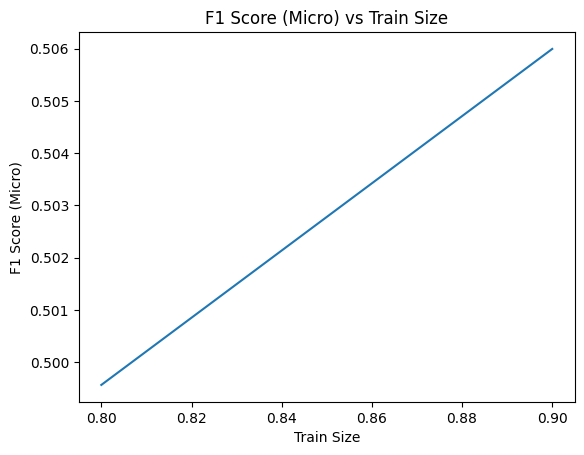

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier

# Define scorer
f1_micro_scorer = make_scorer(f1_score, average='micro')

# Define train sizes
train_sizes = [0.8, 0.9] #np.linspace(0.1, 0.9, 1)

# Initialize Dictionary to store scores for each train_size
scores_dict = {}

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df_preprocessed['genres'])

for train_size in train_sizes:
    # Split data for cross-validation
    X_train, X_test, Y_train, Y_test = train_test_split(df_preprocessed['tokens'], Y, 
                                                        train_size=train_size, 
                                                        random_state=42,
                                                        shuffle=True, 
                                                        stratify=Y)
    
    # get shape of train and test data
    print("Train: ",X_train.shape,Y_train.shape,"Test: ",(X_test.shape,Y_test.shape))

    # Define and fit pipeline
    pipeline = make_pipeline(TfidfVectorizer(), OneVsRestClassifier(estimator=RandomForestClassifier(), n_jobs=-1))

    # Get cross-validated predictions
    cv_predictions = cross_val_predict(pipeline, X_train, Y_train, cv=2, method='predict_proba')
    

    # Set a threshold for the probability score
    threshold = 0.3

    # Convert the probability score into binary matrix
    Y_pred = (cv_predictions >= threshold).astype(int)

    # Calculate F1 scores and append to dictionary for this train-size
    f1_micro = f1_score(Y_train, Y_pred, average='micro')
    scores_dict[train_size] = f1_micro

# Plot the scores
plt.plot(list(scores_dict.keys()), list(scores_dict.values()))
plt.xlabel('Train Size')
plt.ylabel('F1 Score (Micro)')
plt.title('F1 Score (Micro) vs Train Size')
plt.show()



# Predictions

# Evaluation